In [1]:
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import photutils 
import math
import glob
import pdb

## Create the functions

In [2]:
def create_aperture_from_ds9_region(region_file):
    
    # opening the region file as if it were a text file.
    f = open(region_file,'r')
    for i in range(3):
        f.readline()
    region_text = f.readS()
    #print(region_text)
    
    # splitting the read text into individual elements in a list.
    regions = region_text.split('\n')
    try:
        regions.remove('')
    except:
        pass
    src_apertures,bkg_apertures = [],[] 

    for region in regions:
        value_text = region.split('(')[1].split(')')[0]
        pos_x,pos_y,r_in,r_out = np.array(value_text.split(','),dtype = float)
        
        src_apertures.append(photutils.CircularAperture((pos_x,pos_y), r=r_in))
        bkg_apertures.append(photutils.CircularAnnulus((pos_x,pos_y), r_in=r_in, r_out=r_out))

    #print(src_apertures)
    #print(bkg_apertures)
    return src_apertures,bkg_apertures

def perform_aperture_photometry(fits_file, ann_reg_fn):
    # opening the fits file itself and getting the image data.
    hdu = fits.open(fits_file)
    #print(hdu)
    raw_image = hdu[0].data
    #print(raw_image)
    
    image = np.copy(raw_image)
    #print(image)
    image[raw_image <= 0] = 1    
    error = np.sqrt(image)
    #print(error)
    src_aps,bkg_aps = create_aperture_from_ds9_region(ann_reg_fn)
    
    src_sums, src_errors = [],[]
    for i in range(len(src_aps)):
        src_table = photutils.aperture_photometry(image, src_aps[i], error=error)
        bkg_table = photutils.aperture_photometry(image, bkg_aps[i], error=error)

        # finds the mean background value
        bkg_mean = bkg_table['aperture_sum'][0] / bkg_aps[i].area
        bkg_mean_err = bkg_table['aperture_sum_err'][0] / bkg_aps[i].area 

        # pdb.set_trace()  
        # finds the total source intensity of the stellar object
        src_sum = src_table['aperture_sum'][0] - bkg_mean*src_aps[i].area
        src_error = np.sqrt(src_table['aperture_sum_err'][0]**2 + (bkg_aps[i].area*bkg_mean_err)**2)

        # appending to the list.
        src_sums.append(src_sum) #this is the sum
        src_errors.append(src_error) #this is the error

    #print(src_sum)
    return np.array(src_sums),np.array(src_errors)



# Kepler 685

In [29]:
path ='iae3080'
files = glob.glob(path +'/*.fts')

In [37]:
files

['iae3080\\iae30800.fts',
 'iae3080\\iae30801.fts',
 'iae3080\\iae30802.fts',
 'iae3080\\iae30803.fts']

In [30]:
#creating arrays for counts and errors
light_data685308 = []
error685308 = []
for x in files:
    counts, err = perform_aperture_photometry(x, 'trythis') 
    light_data685308.append(counts[0])
    error685308.append(err[0])
print(counts)
print(err)
print(error685308)
print(light_data685308)

[302.52909451]
[1321.50757319]
[1320.42704319919, 1330.5116323237505, 1320.8037803744526, 1321.5075731851293]
[46675.971884937666, -4693.524943819008, 493.87438630333054, 302.52909451464075]


In [31]:
np.savetxt("light_data685308.csv", light_data685308)  
np.savetxt("light_data_error685308.csv", error685308)
#added number at the end kepler## (first # is which star and the second is the day code) did this for both

In [32]:
#intial time - 1:37:17.62 UTC 02:05:48.52
#final time - 5:34:17.62 UTC 04:45:19.41
headers=[]
for i in range(4):
    headers.append((fits.open(files[i])[0].header)['TIME-OBS'])

headerrobs000= fits.open(files[0])[0].header
dateobs000= (headerrobs000["TIME-OBS"])

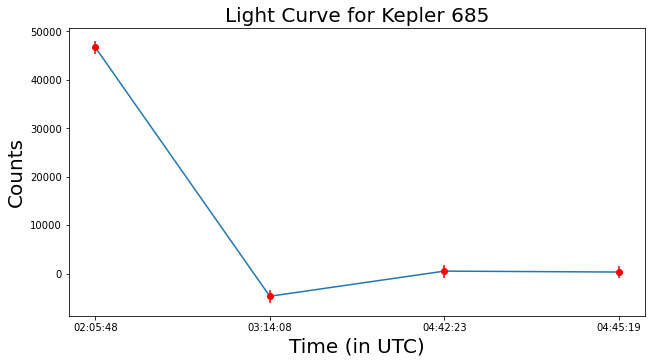

In [33]:
#making the x-axis labels legable and allows to control the number of labels on the x axis
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
#ax.set_xticks([x for x in range(0, 234, 30)])
ax.plot(headers, light_data685308)

#labeling
plt.ylabel("Counts", fontdict = {'fontsize' : 20})
plt.xlabel("Time (in UTC)", fontdict = {'fontsize' : 20})
plt.title("Light Curve for Kepler 685", fontdict = {'fontsize' : 20})
#plotting data
plt.errorbar(headers, light_data685308, yerr=np.transpose(error685308), color='red', ls="", marker="o")

plt.show()

# Kepler 64 on 11-26-2023

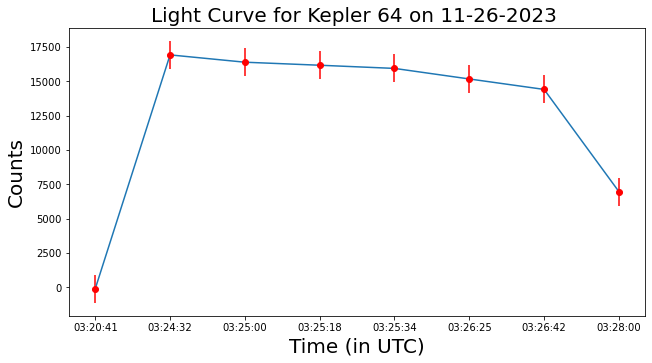

In [34]:
path ='ikepler64330'
files = glob.glob(path +'/*.fts')

#y axis and error
light_data64330 = []
error64330 = []
for x in files:
    counts, err = perform_aperture_photometry(x, 'kepler64330') 
    light_data64330.append(counts[0])
    error64330.append(err[0])

#making csv files
np.savetxt("light_data64330.csv", light_data64330)  
np.savetxt("light_data_error64330.csv", error64330)

#x axis
headers=[]
for i in range(8):
    headers.append((fits.open(files[i])[0].header)['TIME-OBS'])
headerrobs000= fits.open(files[0])[0].header
dateobs000= (headerrobs000["TIME-OBS"])

#actual graphing time
#making the x-axis labels legable and allows to control the number of labels on the x axis
fig = plt.figure(figsize=(10, 5))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
#ax.set_xticks([x for x in range(0, 234, 30)])
ax.plot(headers, light_data64330)
#labeling
plt.ylabel("Counts", fontdict = {'fontsize' : 20})
plt.xlabel("Time (in UTC)", fontdict = {'fontsize' : 20})
plt.title("Light Curve for Kepler 64 on 11-26-2023 ", fontdict = {'fontsize' : 20})
#plotting data
plt.errorbar(headers, light_data64330, yerr=np.transpose(error64330), color='red', ls="", marker="o")
plt.show()

# Kepler 64 on 11-23-2023

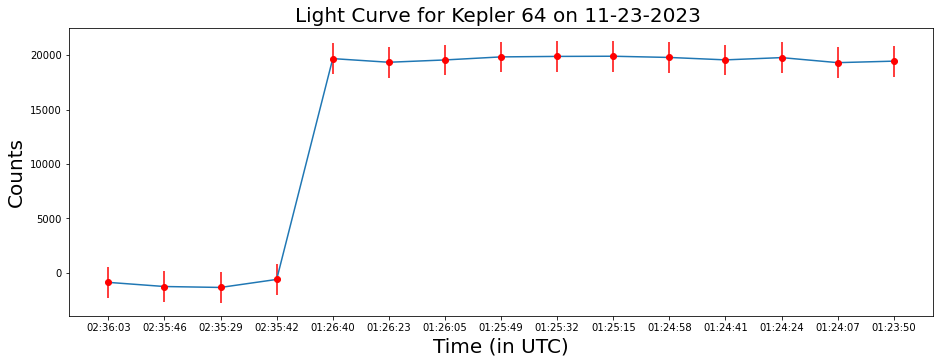

In [48]:
path ='ikepler64327'
files = glob.glob(path +'/*.fts')

#y axis and error
light_data64327 = []
error64327 = []
for x in files:
    counts, err = perform_aperture_photometry(x, 'kepler64327') 
    light_data64327.append(counts[0])
    error64327.append(err[0])

#making csv files
np.savetxt("light_data64327.csv", light_data64327)  
np.savetxt("light_data_error64327.csv", error64327)

#x axis
headers=[]
for i in range(15):
    headers.append((fits.open(files[i])[0].header)['TIME-OBS'])
headerrobs000= fits.open(files[0])[0].header
dateobs000= (headerrobs000["TIME-OBS"])

#actual graphing time
#making the x-axis labels legable and allows to control the number of labels on the x axis
fig = plt.figure(figsize=(15, 5))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
#ax.set_xticks([x for x in range(0, 2, 3)])
ax.plot(headers, light_data64327)
#labeling
plt.ylabel("Counts", fontdict = {'fontsize' : 20})
plt.xlabel("Time (in UTC)", fontdict = {'fontsize' : 20})
plt.title("Light Curve for Kepler 64 on 11-23-2023 ", fontdict = {'fontsize' : 20})
#plotting data
plt.errorbar(headers, light_data64327, yerr=np.transpose(error64327), color='red', ls="", marker="o")
plt.show()

# Kepler 64 on 11-21-2023

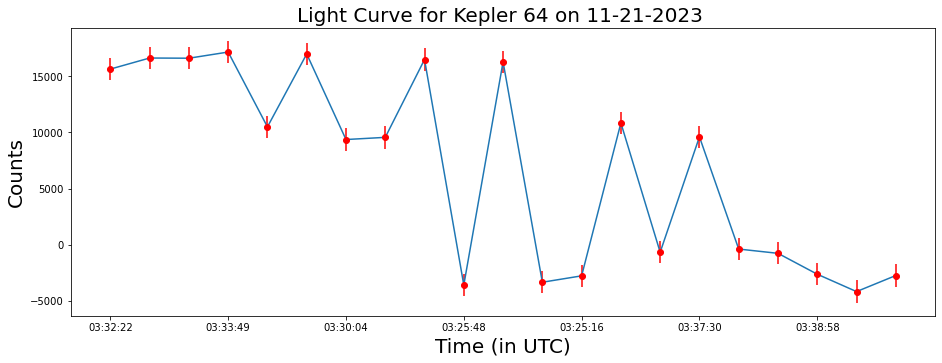

In [54]:
path ='ikepler64325'
files = glob.glob(path +'/*.fts')

#y axis and error
light_data64325 = []
error64325 = []
for x in files:
    counts, err = perform_aperture_photometry(x, 'kepler64325') 
    light_data64325.append(counts[0])
    error64325.append(err[0])

#making csv files
np.savetxt("light_data64325.csv", light_data64325)  
np.savetxt("light_data_error64325.csv", error64325)

#x axis
headers=[]
for i in range(21):
    headers.append((fits.open(files[i])[0].header)['TIME-OBS'])
headerrobs000= fits.open(files[0])[0].header
dateobs000= (headerrobs000["TIME-OBS"])

#actual graphing time
#making the x-axis labels legable and allows to control the number of labels on the x axis
fig = plt.figure(figsize=(15, 5))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.set_xticks([x for x in range(0, 20, 3)])
ax.plot(headers, light_data64325)
#labeling
plt.ylabel("Counts", fontdict = {'fontsize' : 20})
plt.xlabel("Time (in UTC)", fontdict = {'fontsize' : 20})
plt.title("Light Curve for Kepler 64 on 11-21-2023 ", fontdict = {'fontsize' : 20})
#plotting data
plt.errorbar(headers, light_data64325, yerr=np.transpose(error64325), color='red', ls="", marker="o")
plt.show()